In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from xailib.data_loaders.dataframe_loader import prepare_dataframe

from xailib.explainers.lime_explainer import LimeXAITabularExplainer
from xailib.explainers.lore_explainer import LoreTabularExplainer
from xailib.explainers.shap_explainer_tab import ShapXAITabularExplainer

from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

### Load the dataset and prepare it

In [2]:
source_file = 'datasets/german_credit.csv'
class_field = 'default'
# Load and transform dataset 
df = pd.read_csv(source_file, skipinitialspace=True, na_values='?', keep_default_na=True)

In [3]:
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = prepare_dataframe(df, class_field)

### Split the dataset into train and test and scale it

In [4]:
test_size = 0.3
random_state = 42
X_train, X_test, Y_train, Y_test = train_test_split(df[feature_names], df[class_field],
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=df[class_field])



### Define and train a logistic regression model

In [5]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

bb = LogisticRegression(C=1, penalty='l2')
bb.fit(X_scaled, Y_train.values)
# pass the model to the wrapper to use it in the XAI lib
bbox = sklearn_classifier_wrapper(bb)

In [6]:
# select a record to explain
inst = X_train.iloc[182].values
print('Instance ',inst[0:10])
print('True class ',Y_train.iloc[18])
print('Predicted class ',bb.predict(inst.reshape(1, -1)))

Instance  [   48 12169     4     4    36     1     1     1     0     0]
True class  1
Predicted class  [1]


### SHAP explainer
##### We first define the explainer method we want to use: SHAP. It produces feature importance. Then, we can define a dictionary containing the SHAP's parameters we want. 
##### Explainer can be: linear, tree, kernel, deep
##### X_train is the training set we want the explainer to train on. It can be all the training set used for the training of the target model, just a piece of it or we can apply a clustering algorithm on it. 

In [7]:
explainer = ShapXAITabularExplainer(bbox, feature_names)
config = {'explainer' : 'linear', 'X_train' : X_train.iloc[0:100].values, 'feature_pert' : 'interventional'}
explainer.fit(config)

#### We explain the instance and obtain the SHAP values

In [8]:
print('building an explanation')
exp = explainer.explain(inst)
print(exp)

building an explanation


##### We can use the method plot_shap_values to get a visual representation. 
##### Parameters: feature_names, the list of features, exp, the explanation we want to plot, start and end, which denotes the range of features we want to plot

In [9]:
exp.plot_features_importance()

alt.VConcatChart(...)

### LORE explainer
##### We first define the explainer method we want to use: LORE. It produces rules and counterfactual rules. We can define a dictionary containing the LORE's parameters we want. 
##### neigh_type can be: random, genetic, rndgen, geneticp, rndgenp

In [27]:
explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'geneticp', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(df, class_field, config)
exp = explainer.explain(inst)
print(exp)

r = { account_check_status=< 0 DM > 0.02, duration_in_month <= 18.17, credit_history=critical account/ other credits existing (not at this bank) > 0.60 } --> { default: 0 }
c = { { account_check_status=< 0 DM <= 0.02, duration_in_month > 23.50, installment_as_income_perc > 3.50, credit_amount > 10220.50 } }


### LIME explainer
##### We first define the explainer method we want to use: LIME. It produces feature importances. We can define a dictionary containing the LIME's parameters we want. 
##### There are several parameters we can define: feature selection, discretize continuous, discretizer, sample_around_instance, kernel width, kernel.

In [28]:
limeExplainer = LimeXAITabularExplainer(bbox)
config = {'feature_selection': 'lasso_path'}
limeExplainer.fit(df, class_field, config)
lime_exp = limeExplainer.explain(inst)
print(lime_exp.as_list())

[('duration_in_month', 0.041030023122190395), ('account_check_status=no checking account', -0.034431077127694026), ('account_check_status=< 0 DM', 0.03295563757384989), ('credit_history=critical account/ other credits existing (not at this bank)', -0.023006361353573344), ('age', -0.019678287494298112), ('savings=... < 100 DM', 0.016724489057350675), ('property=unknown / no property', 0.015060714844774196), ('other_installment_plans=bank', 0.01458041100400043), ('installment_as_income_perc', 0.013514895239349546), ('credit_amount', 0.013439018418982571)]


##### To plot the explanation, we pass the explanation as a list (tuples, where the first element is the feature name and the second the actual feature importance), start and end of the range of features we want to visualize.

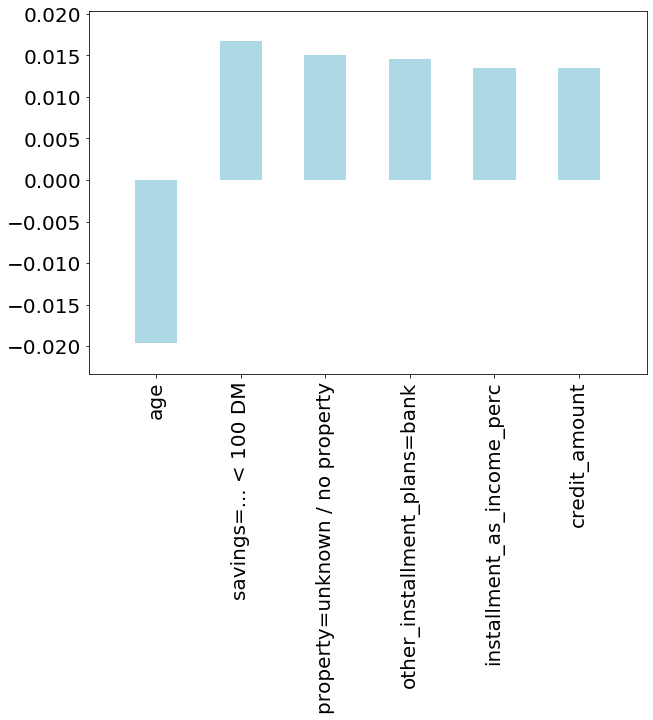

In [29]:
limeExplainer.plot_lime_values(lime_exp.as_list(), 4, 15)

In [30]:
 feature_names

['duration_in_month',
 'credit_amount',
 'installment_as_income_perc',
 'present_res_since',
 'age',
 'credits_this_bank',
 'people_under_maintenance',
 'account_check_status=0 <= ... < 200 DM',
 'account_check_status=< 0 DM',
 'account_check_status=>= 200 DM / salary assignments for at least 1 year',
 'account_check_status=no checking account',
 'credit_history=all credits at this bank paid back duly',
 'credit_history=critical account/ other credits existing (not at this bank)',
 'credit_history=delay in paying off in the past',
 'credit_history=existing credits paid back duly till now',
 'credit_history=no credits taken/ all credits paid back duly',
 'purpose=(vacation - does not exist?)',
 'purpose=business',
 'purpose=car (new)',
 'purpose=car (used)',
 'purpose=domestic appliances',
 'purpose=education',
 'purpose=furniture/equipment',
 'purpose=radio/television',
 'purpose=repairs',
 'purpose=retraining',
 'savings=.. >= 1000 DM ',
 'savings=... < 100 DM',
 'savings=100 <= ... < 500 DM',
 'savings=500 <= ... < 1000 DM ',
 'savings=unknown/ no savings account',
 'present_emp_since=.. >= 7 years',
 'present_emp_since=... < 1 year ',
 'present_emp_since=1 <= ... < 4 years',
 'present_emp_since=4 <= ... < 7 years',
 'present_emp_since=unemployed',
 'personal_status_sex=female : divorced/separated/married',
 'personal_status_sex=male : divorced/separated',
 'personal_status_sex=male : married/widowed',
 'personal_status_sex=male : single',
 'other_debtors=co-applicant',
 'other_debtors=guarantor',
 'other_debtors=none',
 'property=if not A121 : building society savings agreement/ life insurance',
 'property=if not A121/A122 : car or other, not in attribute 6',
 'property=real estate',
 'property=unknown / no property',
 'other_installment_plans=bank',
 'other_installment_plans=none',
 'other_installment_plans=stores',
 'housing=for free',
 'housing=own',
 'housing=rent',
 'job=management/ self-employed/ highly qualified employee/ officer',
 'job=skilled employee / official',
 'job=unemployed/ unskilled - non-resident',
 'job=unskilled - resident',
 'telephone=none',
 'telephone=yes, registered under the customers name ',
 'foreign_worker=no',
 'foreign_worker=yes']

### Define and train a RFClassifier

In [31]:
bb = RandomForestClassifier(n_estimators=20, random_state=random_state)
bb.fit(X_train.values, Y_train.values)
bbox = sklearn_classifier_wrapper(bb)   

In [32]:
explainer = ShapXAITabularExplainer(bbox, feature_names)
config = {'explainer' : 'kernel', 'X_train' : X_train.iloc[0:100].values}
explainer.fit(config)

In [33]:
inst = X_train.iloc[147].values
print('Instance ',inst[0:10])
print('True class ',Y_train.iloc[8])
print('Predicted class ',bb.predict(inst.reshape(1, -1)))

Instance  [ 15 975   2   3  25   2   1   0   1   0]
True class  0
Predicted class  [0]


In [34]:
print('building an explanation')
exp = explainer.explain(inst)
print(exp.exp)

building an explanation
[array([ 0.0491598 ,  0.        ,  0.02659004,  0.00268159,  0.02568701,
        0.        ,  0.00164579,  0.02145391, -0.02818686,  0.        ,
       -0.03056253,  0.        ,  0.06283695,  0.        ,  0.00914178,
        0.        ,  0.00407025,  0.        ,  0.01315378,  0.        ,
        0.        ,  0.        ,  0.        , -0.00904386,  0.00393268,
        0.        ,  0.        ,  0.0036391 ,  0.00016756,  0.        ,
        0.        ,  0.00786819,  0.01210724,  0.01364761,  0.        ,
        0.        ,  0.00595796,  0.00947636,  0.00286916,  0.00970114,
        0.        ,  0.        ,  0.        ,  0.02682513,  0.        ,
       -0.01373546,  0.00846181,  0.01425814,  0.01662137,  0.00266923,
        0.        ,  0.01900795,  0.00125688,  0.00091503,  0.00078302,
        0.00113648,  0.00231256,  0.        ,  0.00937367,  0.00361952,
        0.        ]), array([-0.0491598 ,  0.        , -0.02659004, -0.00268159, -0.02568701,
        0.       

In [35]:
exp.plot_features_importance()

alt.VConcatChart(...)

### LORE explainer

In [24]:
explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'rndgen', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(df, class_field, config)
exp = explainer.explain(inst)
print(exp)

r = { account_check_status=< 0 DM > 0.51, credit_history=critical account/ other credits existing (not at this bank) > 0.39, other_debtors=co-applicant > -0.12, credit_amount <= 8898.63, present_res_since <= 4.68, purpose=domestic appliances > -0.50, property=if not A121/A122 : car or other, not in attribute 6 <= 0.91 } --> { default: 0 }
c = { { credit_history=critical account/ other credits existing (not at this bank) <= 0.39, duration_in_month > 26.66, purpose=(vacation - does not exist?) > 0.00, age > 35.41 } }


### LIME explainer

In [25]:
limeExplainer = LimeXAITabularExplainer(bbox)
config = {'feature_selection': 'lasso_path'}
limeExplainer.fit(df, class_field, config)
lime_exp = limeExplainer.explain(inst)
print(lime_exp.as_list())

[('account_check_status=no checking account', -0.03195501219244258), ('duration_in_month', 0.030839782539954518), ('account_check_status=< 0 DM', 0.027467865053919995), ('credit_history=critical account/ other credits existing (not at this bank)', -0.026434593932261215), ('other_installment_plans=bank', 0.022949618690951565), ('age', -0.02217886749081485), ('property=real estate', -0.020171926658649253), ('savings=... < 100 DM', 0.017934078733684865), ('installment_as_income_perc', 0.015581579840944694), ('property=unknown / no property', 0.015253540546335095)]


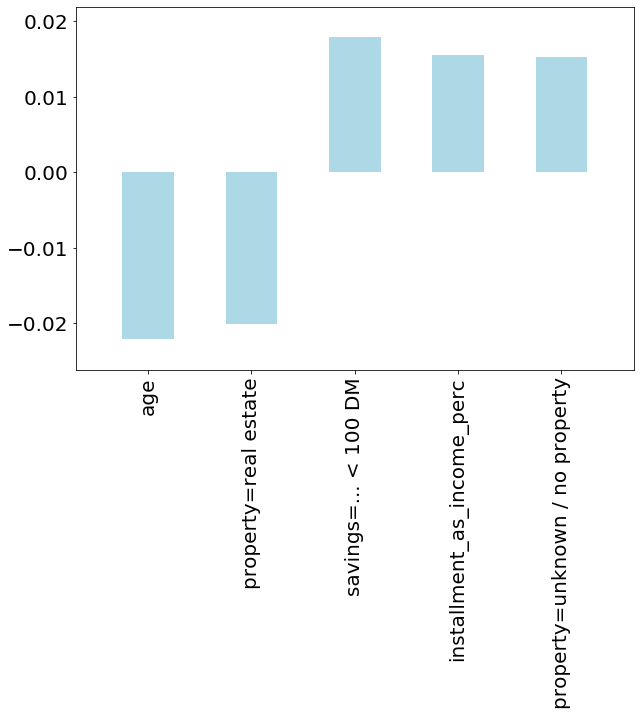

In [26]:
limeExplainer.plot_lime_values(lime_exp.as_list(), 5, 10)